In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import pylab
import warnings as w
import os

%matplotlib inline

In [0]:
import matplotlib
matplotlib.rcParams.update({'font.size':14})
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 14
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2

In [3]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
!unzip UCI\ HAR\ Dataset.zip

--2020-05-31 11:40:13--  https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60999314 (58M) [application/x-httpd-php]
Saving to: ‘UCI HAR Dataset.zip’

UCI HAR Dataset.zip 100%[===================>]  58.17M  16.4MB/s    in 4.5s    

2020-05-31 11:40:18 (12.8 MB/s) - ‘UCI HAR Dataset.zip’ saved [60999314/60999314]

Archive:  UCI HAR Dataset.zip
   creating: UCI HAR Dataset/
  inflating: UCI HAR Dataset/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/UCI HAR Dataset/
  inflating: __MACOSX/UCI HAR Dataset/._.DS_Store  
  inflating: UCI HAR Dataset/activity_labels.txt  
  inflating: __MACOSX/UCI HAR Dataset/._activity_labels.txt  
  inflating: UCI HAR Dataset/features.txt  
  inflating: __MACOSX/UCI HAR Dataset/._features.txt  
  infl

In [0]:
class SSA(object):
    
    __supported_types = (pd.Series, np.ndarray, list)
    
    def __init__(self, tseries, L, save_mem=True):
        """
        Decomposes the given time series with a singular-spectrum analysis. Assumes the values of the time series are
        recorded at equal intervals.
        
        Parameters
        ----------
        tseries : The original time series, in the form of a Pandas Series, NumPy array or list. 
        L : The window length. Must be an integer 2 <= L <= N/2, where N is the length of the time series.
        save_mem : Conserve memory by not retaining the elementary matrices. Recommended for long time series with
            thousands of values. Defaults to True.
        
        Note: Even if an NumPy array or list is used for the initial time series, all time series returned will be
        in the form of a Pandas Series or DataFrame object.
        """
        
        # Tedious type-checking for the initial time series
        if not isinstance(tseries, self.__supported_types):
            raise TypeError("Unsupported time series object. Try Pandas Series, NumPy array or list.")
        
        # Checks to save us from ourselves
        self.N = len(tseries)
        if not 2 <= L <= self.N/2:
            raise ValueError("The window length must be in the interval [2, N/2].")
        
        self.L = L
        self.orig_TS = pd.Series(tseries)
        self.K = self.N - self.L + 1
        
        # Embed the time series in a trajectory matrix
        self.X = np.array([self.orig_TS.values[i:L+i] for i in range(0, self.K)]).T
        
        # Decompose the trajectory matrix
        self.U, self.Sigma, VT = np.linalg.svd(self.X)
        self.d = np.linalg.matrix_rank(self.X)
        
        self.TS_comps = np.zeros((self.N, self.d))
        
        if not save_mem:
            # Construct and save all the elementary matrices
            self.X_elem = np.array([ self.Sigma[i]*np.outer(self.U[:,i], VT[i,:]) for i in range(self.d) ])

            # Diagonally average the elementary matrices, store them as columns in array.           
            for i in range(self.d):
                X_rev = self.X_elem[i, ::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.V = VT.T
        else:
            # Reconstruct the elementary matrices without storing them
            for i in range(self.d):
                X_elem = self.Sigma[i]*np.outer(self.U[:,i], VT[i,:])
                X_rev = X_elem[::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.X_elem = "Re-run with save_mem=False to retain the elementary matrices."
            
            # The V array may also be very large under these circumstances, so we won't keep it.
            self.V = "Re-run with save_mem=False to retain the V matrix."
        
        # Calculate the w-correlation matrix.
        self.calc_wcorr()
            
    def components_to_df(self, n=0):
        """
        Returns all the time series components in a single Pandas DataFrame object.
        """
        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d
        
        # Create list of columns - call them F0, F1, F2, ...
        cols = ["F{}".format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)
            
    
    def reconstruct(self, indices):
        """
        Reconstructs the time series from its elementary components, using the given indices. Returns a Pandas Series
        object with the reconstructed time series.
        
        Parameters
        ----------
        indices: An integer, list of integers or slice(n,m) object, representing the elementary components to sum.
        """
        if isinstance(indices, int): indices = [indices]
        
        ts_vals = self.TS_comps[:,indices].sum(axis=1)
        return pd.Series(ts_vals, index=self.orig_TS.index)
    
    def calc_wcorr(self):
        """
        Calculates the w-correlation matrix for the time series.
        """
             
        # Calculate the weights
        w = np.array(list(np.arange(self.L)+1) + [self.L]*(self.K-self.L-1) + list(np.arange(self.L)+1)[::-1])
        
        def w_inner(F_i, F_j):
            return w.dot(F_i*F_j)
        
        # Calculated weighted norms, ||F_i||_w, then invert.
        F_wnorms = np.array([w_inner(self.TS_comps[:,i], self.TS_comps[:,i]) for i in range(self.d)])
        F_wnorms = F_wnorms**-0.5
        
        # Calculate Wcorr.
        self.Wcorr = np.identity(self.d)
        for i in range(self.d):
            for j in range(i+1,self.d):
                self.Wcorr[i,j] = abs(w_inner(self.TS_comps[:,i], self.TS_comps[:,j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j,i] = self.Wcorr[i,j]
    
    def plot_wcorr(self, min=None, max=None):
        """
        Plots the w-correlation matrix for the decomposed time series.
        """
        if min is None:
            min = 0
        if max is None:
            max = self.d
        
        if self.Wcorr is None:
            self.calc_wcorr()
        
        ax = plt.imshow(self.Wcorr)
        plt.xlabel(r"$\tilde{F}_i$")
        plt.ylabel(r"$\tilde{F}_j$")
        plt.colorbar(ax.colorbar, fraction=0.045)
        ax.colorbar.set_label("$W_{i,j}$")
        plt.clim(0,1)
        
        # For plotting purposes:
        if max == self.d:
            max_rnge = self.d-1
        else:
            max_rnge = max
        
        plt.xlim(min-0.5, max_rnge+0.5)
        plt.ylim(max_rnge+0.5, min-0.5)

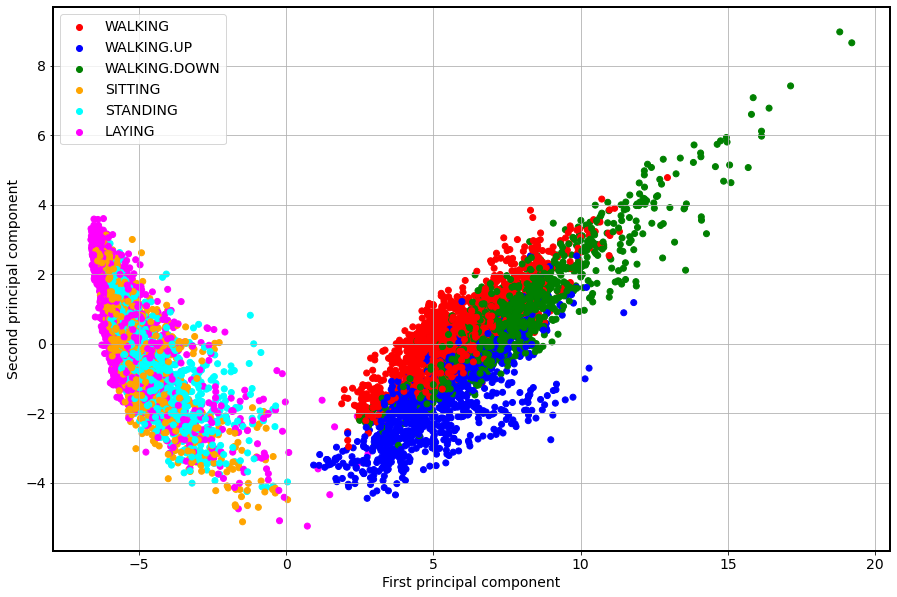

In [5]:
X_train_with_engineered_features = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "X_train.txt"))
y_train = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "y_train.txt"))

y_train_list = list(y_train)
X_unique = np.array([X_train_with_engineered_features[y_train_list.index(l)]
                             for l in sorted(list(set(y_train)))])

legend_labels = ["WALKING", "WALKING.UP", "WALKING.DOWN", "SITTING", "STANDING", "LAYING"]
colors_list = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta']
mapped_colors = [colors_list[int(i)-1] for i in y_train]

from sklearn.decomposition import PCA
pca = PCA()

X_train_pca = pca.fit_transform(X_train_with_engineered_features)

plt.figure(figsize=(15,10))
pylab.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
             c=mapped_colors)
plt.grid()
for idx, x in enumerate(pca.transform(X_unique)):
    plt.scatter(x[0], 
                x[1], 
                c=colors_list[idx], 
                label=legend_labels[idx])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.legend()

In [6]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
]

DATA_PATH = "./"

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)

TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    os.path.join(*[DATASET_PATH, TRAIN, "Inertial Signals/", signal+"train.txt"]) for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    os.path.join(*[DATASET_PATH, TEST, "Inertial Signals/", signal+"test.txt"]) for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = os.path.join(DATASET_PATH, TRAIN, "y_train.txt")
y_test_path = os.path.join(DATASET_PATH, TEST, "y_test.txt")

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)


Dataset is now located at: ./UCI HAR Dataset/


In [7]:
# Input Data 

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 128, 9) (2947, 1) 0.09913992 0.39567086
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


In [0]:
from tqdm.notebook import tqdm

In [9]:
%%time
X_train_new = np.array([])
for x in tqdm(X_train):
    x = x.reshape(9, 128)
    a = np.array([])
    for t in x:
        F_ssa_L5 = SSA(t, 5)
        series = {}
        for i in range(5):
            for j in range(5):
                if F_ssa_L5.Wcorr[i][j] > 0.3 and i < j:
                    if i in series:
                        series[i].append(j)
                    else:
                        series[i] = [j]
                        series[i].append(i)
        slices = [value for value in series.values()]
        for s in slices:
            if len(a) != 0:
                a = np.append(a, F_ssa_L5.reconstruct(s).to_numpy().reshape(1, 128), axis=0)
            else:
                a = F_ssa_L5.reconstruct(s).to_numpy().reshape(1, 128)
    if len(X_train_new) != 0:
        X_train_new = np.append(X_train_new, a[:14].reshape(1,14,128), axis=0)
    else:
        X_train_new = a[:14].reshape(1,14,128)


CPU times: user 15min 26s, sys: 11min 7s, total: 26min 33s
Wall time: 13min 54s


In [10]:
%%time
X_test_new = np.array([])
for x in tqdm(X_test):
    x = x.reshape(9, 128)
    a = np.array([])
    for t in x:
        F_ssa_L5 = SSA(t, 5)
        series = {}
        for i in range(5):
            for j in range(5):
                if F_ssa_L5.Wcorr[i][j] > 0.3 and i < j:
                    if i in series:
                        series[i].append(j)
                    else:
                        series[i] = [j]
                        series[i].append(i)
        slices = [value for value in series.values()]
        for s in slices:
            if len(a) != 0:
                a = np.append(a, F_ssa_L5.reconstruct(s).to_numpy().reshape(1, 128), axis=0)
            else:
                a = F_ssa_L5.reconstruct(s).to_numpy().reshape(1, 128)
    if len(X_test_new) != 0:
        X_test_new = np.append(X_test_new, a[:14].reshape(1,14,128), axis=0)
    else:
        X_test_new = a[:14].reshape(1,14,128)


CPU times: user 5min 55s, sys: 4min 13s, total: 10min 8s
Wall time: 5min 20s


In [11]:
%%time
X_train_new_sigma = np.array([])
for x in tqdm(X_train):
    x = x.reshape(9, 128)
    a = np.array([])
    for t in x:
        F_ssa_L10 = SSA(t, 17)
        if len(a) != 0:
            a = np.append(a, F_ssa_L10.Sigma, axis=0)
        else:
            a = F_ssa_L10.Sigma
    if len(X_train_new_sigma) != 0:
        X_train_new_sigma = np.append(X_train_new_sigma, a, axis=0)
    else:
        X_train_new_sigma = a


CPU times: user 39min 46s, sys: 27min 37s, total: 1h 7min 23s
Wall time: 34min 43s


In [26]:
%%time
X_test_new_sigma = np.array([])
for x in tqdm(X_test):
    x = x.reshape(9, 128)
    a = np.array([])
    for t in x:
        F_ssa_L10 = SSA(t, 17)
        if len(a) != 0:
            a = np.append(a, F_ssa_L10.Sigma, axis=0)
        else:
            a = F_ssa_L10.Sigma
    if len(X_test_new_sigma) != 0:
        X_test_new_sigma = np.append(X_test_new_sigma, a, axis=0)
    else:
        X_test_new_sigma = a


CPU times: user 15min 39s, sys: 10min 53s, total: 26min 33s
Wall time: 13min 41s


In [0]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, concatenate
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, LeakyReLU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Input
from keras.utils import np_utils

In [0]:
X_train = X_train.reshape(X_train.shape[0], 1, 32, -1)
X_train = X_train.astype('float32')
X_train /= np.amax(X_train)
X_train_new = X_train_new.reshape(X_train_new.shape[0], 1, 32, -1)
X_train_new = X_train_new.astype('float32')
X_train_new /= np.amax(X_train_new)
X_train_sigma = X_train_new_sigma.reshape(7352, -1)
X_train_sigma = X_train_sigma.astype('float32')
X_train_sigma /= np.amax(X_train_sigma)
y_train_new = y_train.reshape(-1)
Y_train_new = np_utils.to_categorical(y_train_new, 6)


X_test_new = X_test_new.reshape(X_test_new.shape[0], 1, 32, -1)
X_test_new = X_test_new.astype('float32')
X_test_new /= np.amax(X_test_new)
X_test = X_test.reshape(X_test.shape[0], 1, 32, -1)
X_test = X_test.astype('float32')
X_test /= np.amax(X_test)
X_test_sigma = X_test_new_sigma.reshape(X_test.shape[0], -1)
X_test_sigma = X_test_sigma.astype('float32')
X_test_sigma /= np.amax(X_test_sigma)
Y_test_new = np_utils.to_categorical(y_test.reshape(-1), 6)

In [0]:
x = Input(shape=(1, 32, 36), dtype='float32', name='x')
x_new = Input(shape=(1, 32, 56), dtype='float32', name='x_new')
x_sigma = Input(shape=(153), dtype='float32', name='x_sigma')

x1 = Convolution2D(32, (3, 3), activation='relu', input_shape=(1, 32, 36), data_format='channels_first')(x)
x2 = MaxPooling2D(pool_size=(2,2))(x1)
x3 = Dropout(0.25)(x2)
x4 = Convolution2D(32, (3, 3),activation='relu')(x3)
x5 = MaxPooling2D(pool_size=(2,2))(x4)
x6 = Dropout(0.25)(x5)
x7 = Flatten()(x6)
x8 = Dense(64, activation='relu')(x7)
x9 = Dropout(0.25)(x8)

x_new1 = Convolution2D(32, (3, 3), activation='relu', input_shape=(1, 32, 56), data_format='channels_first')(x_new)
x_new2 = MaxPooling2D(pool_size=(2,2))(x_new1)
x_new3 = Dropout(0.6)(x_new2)
x_new4 = Convolution2D(32, (3, 3),activation='relu')(x_new3)
x_new5 = MaxPooling2D(pool_size=(2,2))(x_new4)
x_new6 = Dropout(0.6)(x_new5)
x_new7 = Flatten()(x_new6)
x_new8 = Dense(64, activation='relu')(x_new7)
x_new9 = Dropout(0.6)(x_new8)

x_sigma1 = Dense(100, activation='relu')(x_sigma)
x_sigma2 = Dropout(0.25)(x_sigma1)
x_sigma3 = Dense(100, activation='relu')(x_sigma2)
x_sigma4 = Dropout(0.25)(x_sigma3)
x_sigma5 = Dense(100, activation='relu')(x_sigma4)
x_sigma6 = Dropout(0.25)(x_sigma5)
x_sigma7 = Dense(100, activation='relu')(x_sigma6)
x_sigma8 = Dropout(0.25)(x_sigma7)
x_sigma9 = Dense(100, activation='relu')(x_sigma8)
x_sigma10 = Dropout(0.25)(x_sigma8)


concatenated = concatenate([x9, x_sigma], axis=-1)
c = Dense(64, activation='relu')(concatenated)
answer = Dense(6, activation='softmax')(c)
model = Model([x, x_sigma], answer)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [99]:
history = model.fit({'x': X_train, 'x_new': X_train_new, 'x_sigma': X_train_sigma}, Y_train_new, epochs=200, validation_split=0.1, batch_size=256,shuffle=True)

Epoch 1/200
26/26 [==============================] - 0s 16ms/step - loss: 1.4603 - accuracy: 0.4167 - val_loss: 0.8683 - val_accuracy: 0.5394
Epoch 2/200
26/26 [==============================] - 0s 10ms/step - loss: 0.7590 - accuracy: 0.6378 - val_loss: 0.5839 - val_accuracy: 0.8030
Epoch 3/200
26/26 [==============================] - 0s 10ms/step - loss: 0.5910 - accuracy: 0.7322 - val_loss: 0.4628 - val_accuracy: 0.8397
Epoch 4/200
26/26 [==============================] - 0s 11ms/step - loss: 0.4805 - accuracy: 0.8071 - val_loss: 0.4084 - val_accuracy: 0.8220
Epoch 5/200
26/26 [==============================] - 0s 10ms/step - loss: 0.4116 - accuracy: 0.8414 - val_loss: 0.3474 - val_accuracy: 0.8465
Epoch 6/200
26/26 [==============================] - 0s 10ms/step - loss: 0.3490 - accuracy: 0.8699 - val_loss: 0.2757 - val_accuracy: 0.8764
Epoch 7/200
26/26 [==============================] - 0s 10ms/step - loss: 0.2974 - accuracy: 0.8910 - val_loss: 0.2638 - val_accuracy: 0.8845
Epoch 

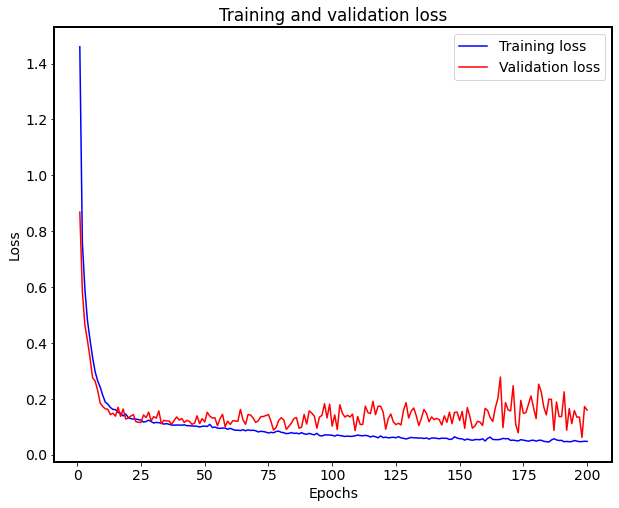

<Figure size 1080x720 with 0 Axes>

In [100]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, 201)
plt.plot(epochs, loss_values, 'b', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.figure(figsize=(15,10))
plt.show()

In [101]:
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x (InputLayer)                  [(None, 1, 32, 36)]  0                                            
__________________________________________________________________________________________________
conv2d_52 (Conv2D)              (None, 32, 30, 34)   320         x[0][0]                          
__________________________________________________________________________________________________
max_pooling2d_52 (MaxPooling2D) (None, 16, 15, 34)   0           conv2d_52[0][0]                  
__________________________________________________________________________________________________
dropout_143 (Dropout)           (None, 16, 15, 34)   0           max_pooling2d_52[0][0]           
___________________________________________________________________________________________

In [102]:
predictions= model.predict({'x': X_test, 'x_new': X_test_new, 'x_sigma': X_test_sigma})
y_pred = [np.argmax(x) for x in predictions]
y_test = y_test.reshape(-1)
(y_pred == y_test).mean()

0.9155072955548015

In [103]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96       496
           1       0.98      0.95      0.96       471
           2       0.91      1.00      0.95       420
           3       0.82      0.77      0.80       491
           4       0.81      0.84      0.83       532
           5       1.00      1.00      1.00       537

    accuracy                           0.92      2947
   macro avg       0.92      0.92      0.92      2947
weighted avg       0.92      0.92      0.92      2947



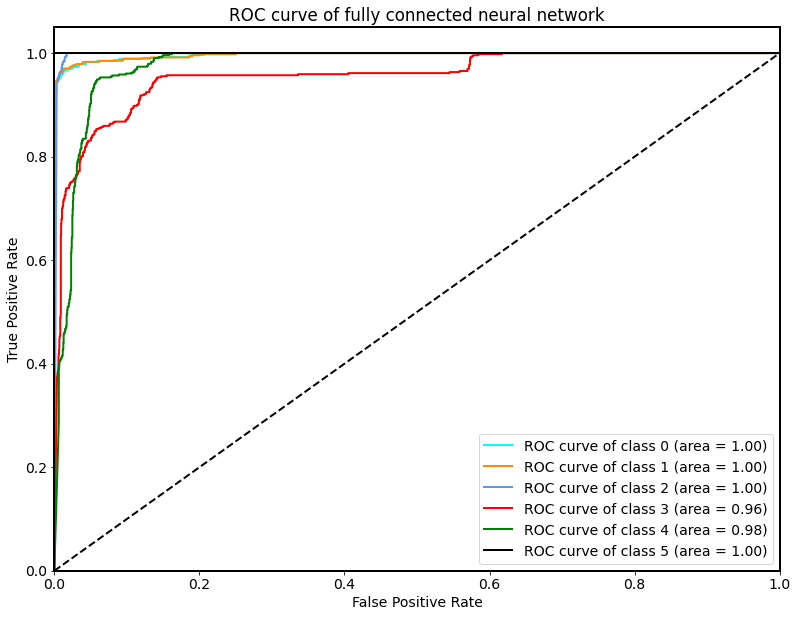

In [104]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle

y_score = predictions

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_new[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
lw = 2
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

# Plot all ROC curves
plt.figure(figsize=(13,10))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'black'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of fully connected neural network')
plt.legend(loc="lower right")
plt.show()